## 1. Import Libraries

In [1]:
import psycopg2

import pandas as pd
import numpy as np

import xgboost as xgb

import tensorflow as tf

import mimic_iv_utils as utils

from functools import reduce

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn import metrics

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib import pyplot as plt

## 2. Connect to DB

In [2]:
# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'mimiciv'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

## 3. Fetch Data

In [3]:
static = utils.getStaticFeatures()
first_lab = utils.getLabFeatures(duration=24)
last_lab = utils.getLabFeatures(mode='last', duration=24)
first_vitals = utils.getVitalsFeatures(duration=24)
last_vitals = utils.getVitalsFeatures(mode='last', duration=24)
max_vitals = utils.getMinMaxVitalsFeatures(mode='max', duration=24)
min_vitals = utils.getMinMaxVitalsFeatures(duration=24)
avg_vitals = utils.getMinMaxVitalsFeatures(mode='avg', duration=24)
mortality = utils.getInhospitalMortality()

## 4. Unique Patients

In [6]:
query = query_schema + \
"""
SELECT
icu.stay_id
FROM
mimiciv.icustays icu
INNER JOIN mimiciv.admissions adm
ON adm.hadm_id = icu.hadm_id
INNER JOIN mimiciv.patients pat
ON pat.subject_id = adm.subject_id
WHERE (icu.outtime >= icu.intime + interval '24 hour')
AND (FLOOR(DATE_PART('day', adm.admittime - make_timestamp(pat.anchor_year, 1, 1, 0, 0, 0))/365.0) + pat.anchor_age) > 18
AND icu.intime = (
	SELECT MAX(icu_max.intime) FROM mimiciv.icustays icu_max WHERE icu_max.subject_id = pat.subject_id
)"""

filtered = pd.read_sql_query(query, con)

In [7]:
dfs = [filtered, static, first_lab, last_lab, first_vitals, last_vitals, max_vitals, min_vitals, avg_vitals, mortality]
data = reduce(lambda  left, right: pd.merge(left, right, on=['stay_id'], how='inner'), dfs)

In [12]:
X = data.values
y = X[:,-1]
y = y.astype('int')
X = X[:,0:-1]
X_header = [x for x in data.columns.values]
X_header = X_header[0:-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train_array = np.asarray(X_train).astype('float32')
X_test_array = np.asarray(X_test).astype('float32')
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_train_array)
X_train_imputed = imp_mean.transform(X_train_array)
X_test_imputed = imp_mean.transform(X_test_array)
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train_imputed)
X_train_noralized = normalizer(X_train_imputed)
X_test_noralized = normalizer(X_test_imputed)

model = Sequential()
model.add(layers.Dense(X_train.shape[1], activation=tf.nn.relu, kernel_initializer='he_normal', bias_initializer='zeros'))
model.add(layers.Dense(40, activation=tf.nn.relu, kernel_initializer='he_normal', bias_initializer='zeros'))
model.add(layers.Dense(1, activation=tf.nn.sigmoid, kernel_initializer='he_normal', bias_initializer='zeros'))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.fit(X_train_noralized, y_train, validation_data=(X_test_noralized, y_test), epochs=5, batch_size=256)

probs = model.predict(X_test_noralized)

Epoch 1/5
131/131 [==============================] - 24s 6ms/step - loss: 0.4879 - accuracy: 0.7606 - val_loss: 0.2621 - val_accuracy: 0.8931
Epoch 2/5
131/131 [==============================] - 0s 2ms/step - loss: 0.2489 - accuracy: 0.8973 - val_loss: 0.2515 - val_accuracy: 0.8944
Epoch 3/5
131/131 [==============================] - 0s 2ms/step - loss: 0.2340 - accuracy: 0.9015 - val_loss: 0.2530 - val_accuracy: 0.8922
Epoch 4/5
131/131 [==============================] - 0s 2ms/step - loss: 0.2268 - accuracy: 0.9044 - val_loss: 0.2472 - val_accuracy: 0.8925
Epoch 5/5
131/131 [==============================] - 0s 2ms/step - loss: 0.2146 - accuracy: 0.9107 - val_loss: 0.2454 - val_accuracy: 0.8935


ROC:  0.9080074340363302
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      7205
           1       0.67      0.46      0.54      1165

    accuracy                           0.89      8370
   macro avg       0.79      0.71      0.74      8370
weighted avg       0.88      0.89      0.88      8370



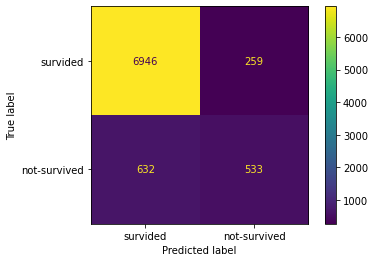

In [14]:
preds = np.around(probs)

roc_score = metrics.roc_auc_score(y_test, probs)

print('ROC: ', roc_score)

classification_report = metrics.classification_report(y_test, preds)
print(classification_report)

cm = confusion_matrix(y_test, preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['survided', 'not-survived'])
disp.plot()

## 5. Unique Admissions

In [15]:
query = query_schema + \
"""
SELECT
icu.stay_id
FROM
mimiciv.icustays icu
INNER JOIN mimiciv.admissions adm
ON adm.hadm_id = icu.hadm_id
INNER JOIN mimiciv.patients pat
ON pat.subject_id = adm.subject_id
WHERE (icu.outtime >= icu.intime + interval '24 hour')
AND (FLOOR(DATE_PART('day', adm.admittime - make_timestamp(pat.anchor_year, 1, 1, 0, 0, 0))/365.0) + pat.anchor_age) > 18
AND icu.intime = (
	SELECT MAX(icu_max.intime) FROM mimiciv.icustays icu_max WHERE icu_max.hadm_id = adm.hadm_id
)"""

filtered = pd.read_sql_query(query, con)

In [16]:
dfs = [filtered, static, first_lab, last_lab, first_vitals, last_vitals, max_vitals, min_vitals, avg_vitals, mortality]
data = reduce(lambda  left, right: pd.merge(left, right, on=['stay_id'], how='inner'), dfs)

In [18]:
X = data.values
y = X[:,-1]
y = y.astype('int')
X = X[:,0:-1]
X_header = [x for x in data.columns.values]
X_header = X_header[0:-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
X_train_array = np.asarray(X_train).astype('float32')
X_test_array = np.asarray(X_test).astype('float32')
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_train_array)
X_train_imputed = imp_mean.transform(X_train_array)
X_test_imputed = imp_mean.transform(X_test_array)
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train_imputed)
X_train_noralized = normalizer(X_train_imputed)
X_test_noralized = normalizer(X_test_imputed)

model = Sequential()
model.add(layers.Dense(X_train.shape[1], activation=tf.nn.relu, kernel_initializer='he_normal', bias_initializer='zeros'))
model.add(layers.Dense(40, activation=tf.nn.relu, kernel_initializer='he_normal', bias_initializer='zeros'))
model.add(layers.Dense(1, activation=tf.nn.sigmoid, kernel_initializer='he_normal', bias_initializer='zeros'))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.fit(X_train_noralized, y_train, validation_data=(X_test_noralized, y_test), epochs=5, batch_size=256)

probs = model.predict(X_test_noralized)

Epoch 1/5
171/171 [==============================] - 2s 4ms/step - loss: 0.3438 - accuracy: 0.8622 - val_loss: 0.2373 - val_accuracy: 0.9101
Epoch 2/5
171/171 [==============================] - 0s 2ms/step - loss: 0.2129 - accuracy: 0.9176 - val_loss: 0.2287 - val_accuracy: 0.9140
Epoch 3/5
171/171 [==============================] - 0s 2ms/step - loss: 0.2025 - accuracy: 0.9196 - val_loss: 0.2241 - val_accuracy: 0.9138
Epoch 4/5
171/171 [==============================] - 0s 2ms/step - loss: 0.1911 - accuracy: 0.9249 - val_loss: 0.2228 - val_accuracy: 0.9139
Epoch 5/5
171/171 [==============================] - 0s 2ms/step - loss: 0.1888 - accuracy: 0.9249 - val_loss: 0.2258 - val_accuracy: 0.9138


ROC:  0.8980047339183357
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      9757
           1       0.73      0.31      0.43      1165

    accuracy                           0.91     10922
   macro avg       0.83      0.65      0.69     10922
weighted avg       0.90      0.91      0.90     10922



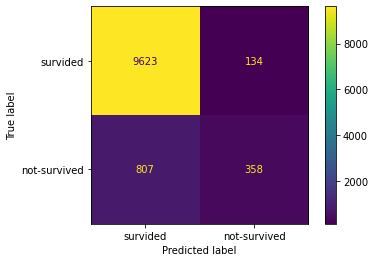

In [20]:
preds = np.around(probs)

roc_score = metrics.roc_auc_score(y_test, probs)

print('ROC: ', roc_score)

classification_report = metrics.classification_report(y_test, preds)
print(classification_report)

cm = confusion_matrix(y_test, preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['survided', 'not-survived'])
disp.plot()